# A quick-start guide to PBjam 
## Using the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class

PBjam is meant to be an easy to use, but also flexible, code for measuring the individual frequencies of solar-like oscillators. This process is broadly speaking broken down into two parts, the mode identification and the peakbagging steps. The [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class is a top-level wrapper and is meant to handle the full peakbagging process for the most part using the default settings in PBjam.

In this tutorial we will just show you how to quickly start peakbagging your favorite stars using the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class. For a detailed description of how PBjam does all this, see the [Advanced guide](https://pbjam.readthedocs.io/en/latest/example-advanced.html). 

### So lets do some peakbagging already!

Ok then! Let's start by initializing the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class, using a target ID and some physical parameters. We'll also add a path to store the output and ask PBjam to make some plots for us.

In [1]:
import pbjam as pb
sess = pb.session(ID='KIC4448777', 
                  numax=(220.0, 3.0), 
                  dnu=(16.97, 0.05), 
                  teff=(4750, 250), 
                  bp_rp=(1.34, 0.1),
                  path = '.')

Querying MAST for KIC4448777


We then call the class instance to begin the actual peakbagging, here using 7 radial orders. 

**Warning:** The next step might take several minutes to run

 18%|█▊        | 3500/20000 [00:35<02:47, 98.35it/s] 


Converged after 3500 iterations.


 10%|█         | 2000/20000 [01:34<14:08, 21.20it/s]


Converged after 2000 iterations.


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [back, height2, height0, l2, l0, width2, width0]
100%|██████████| 2000/2000 [00:35<00:00, 55.70it/s]


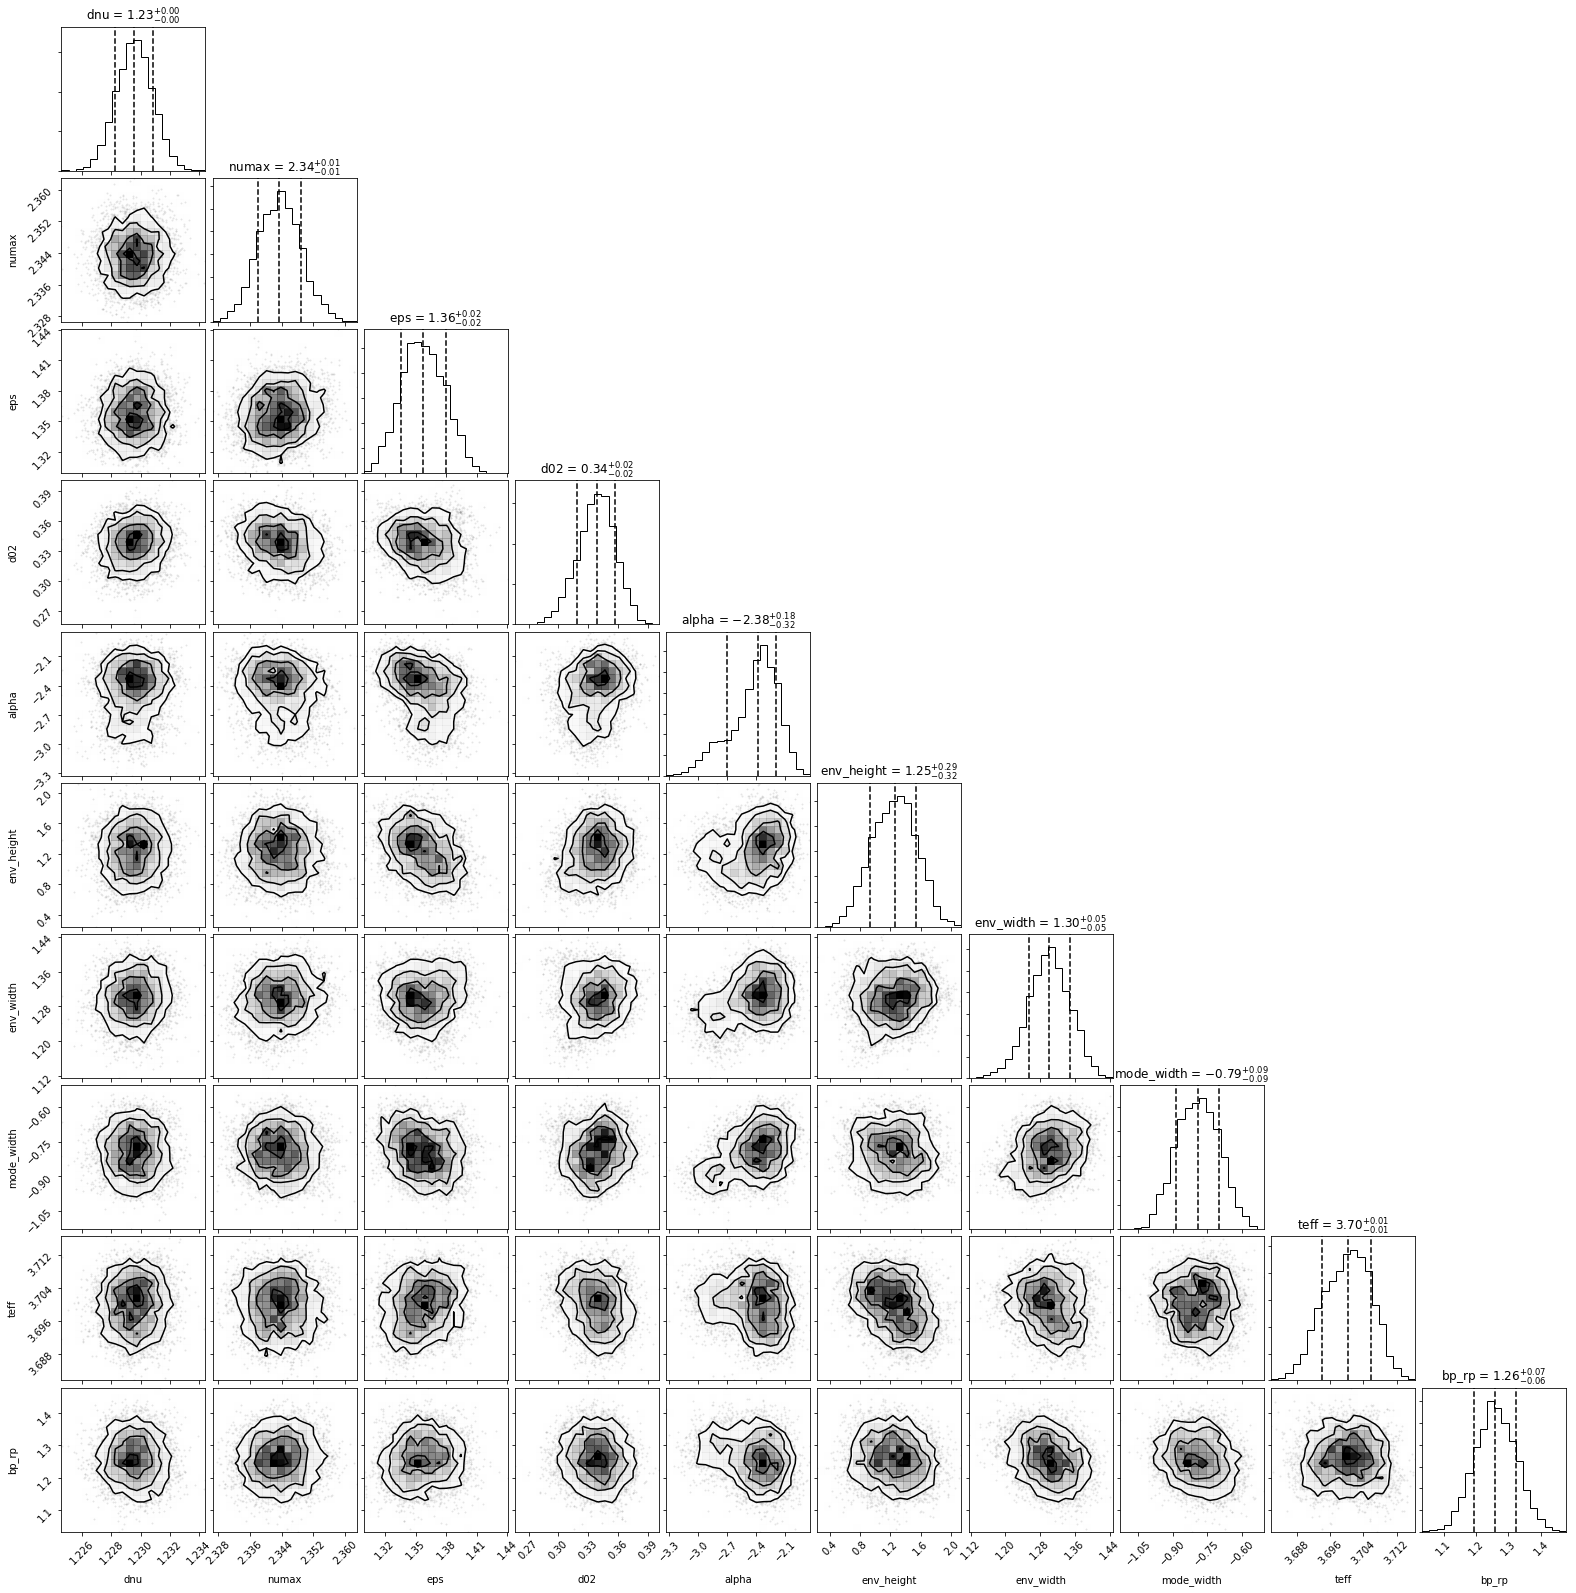

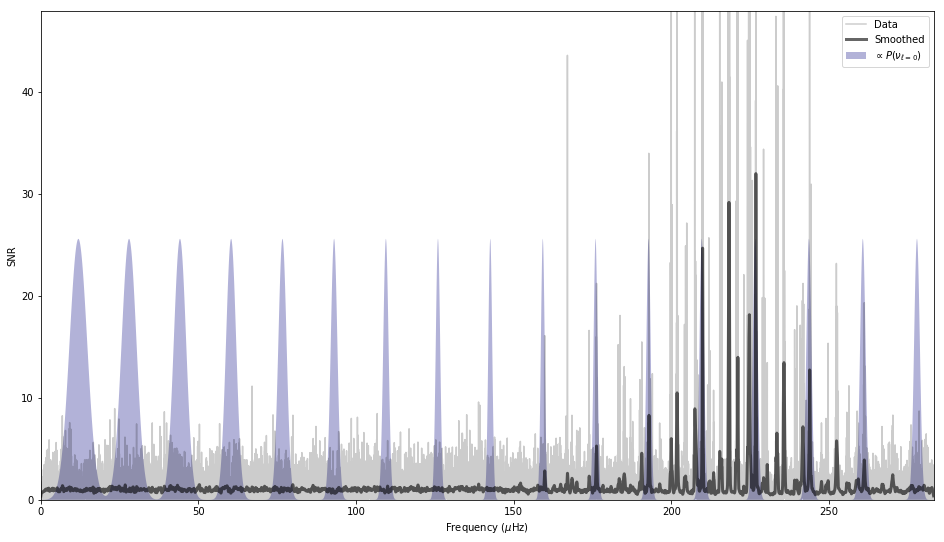

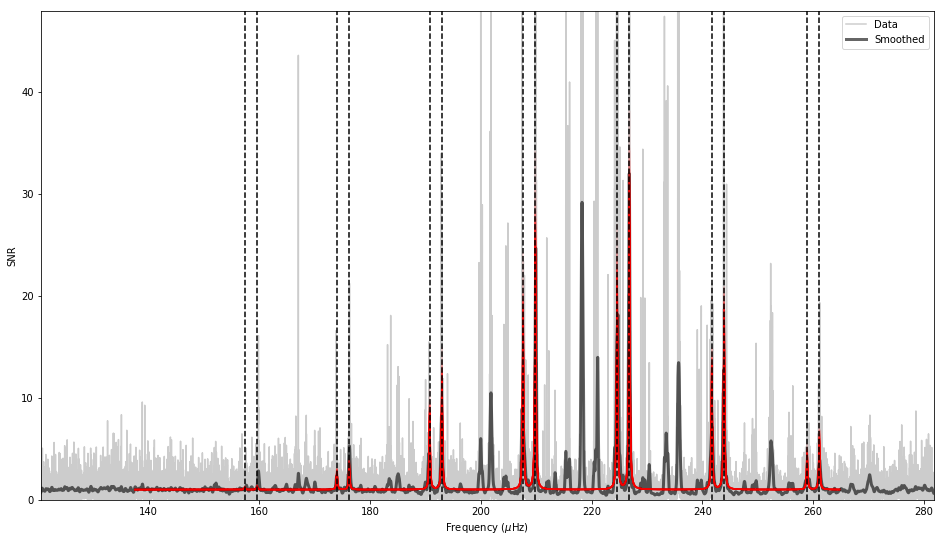

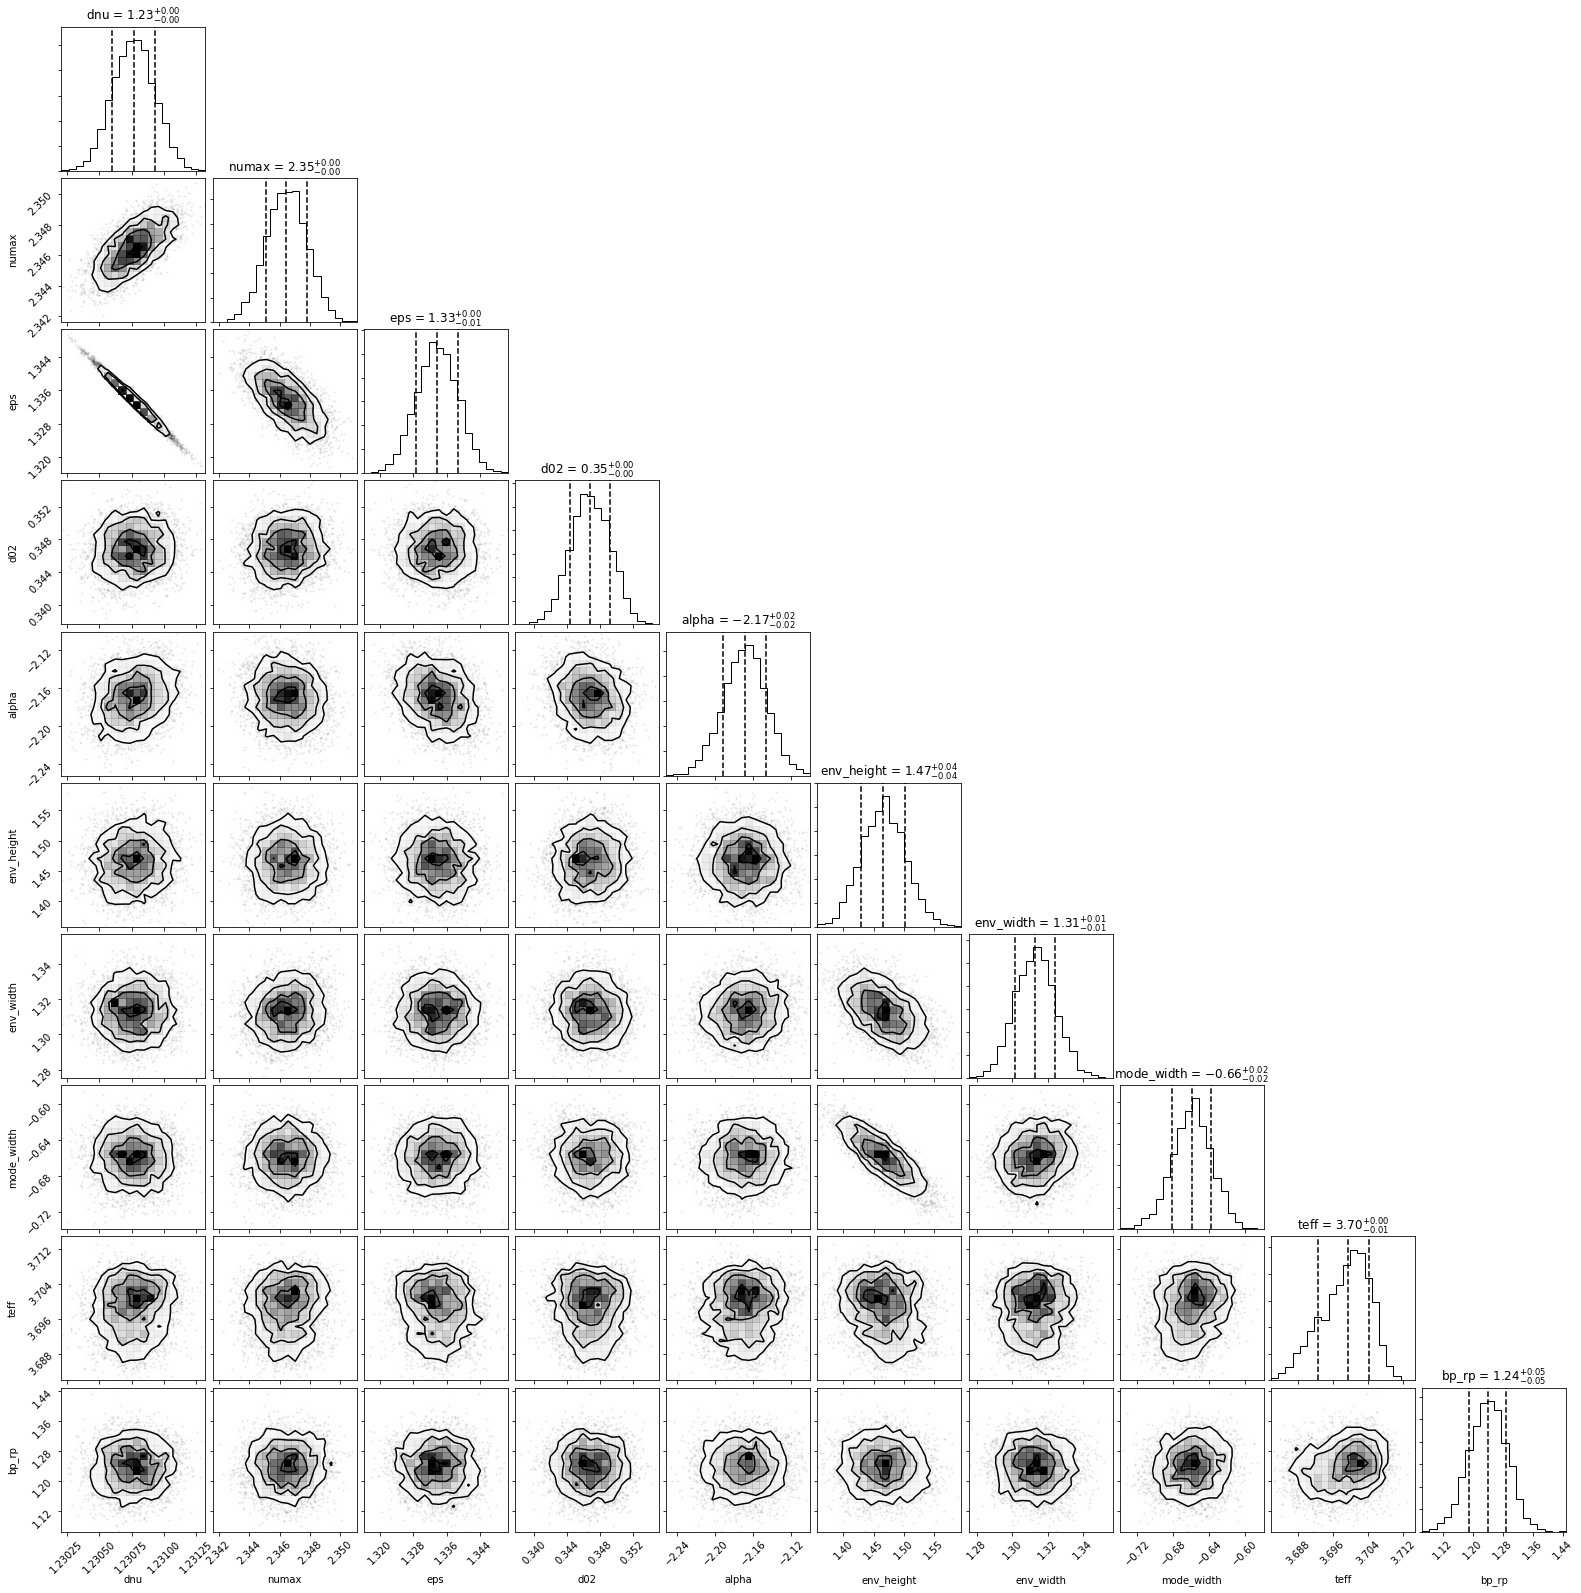

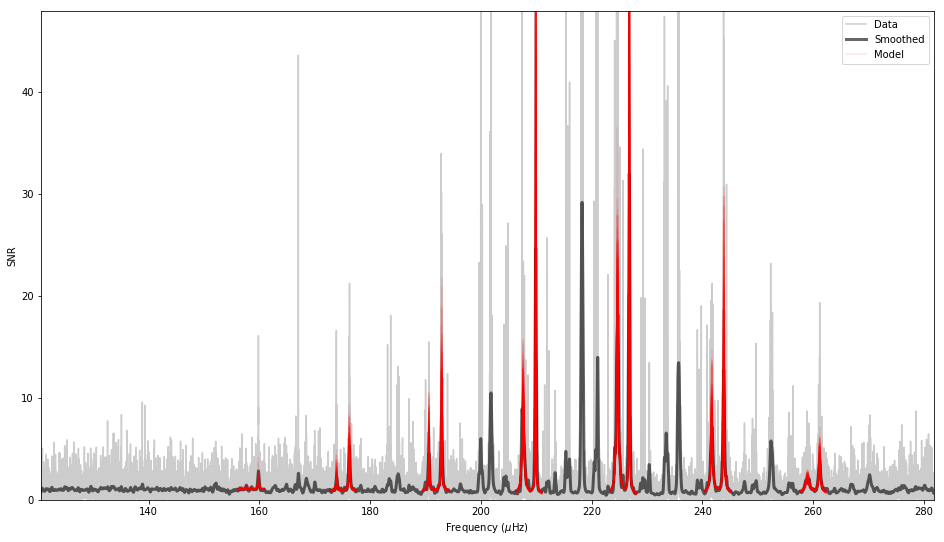

In [2]:
sess(norders = 7, make_plots=True);

And that's it!

### What's actually going on here?
To peakbag a star PBjam needs relatively few input values. In the simplest case it just needs the name of the target, to look up the lightcurve on the [MAST](https://archive.stsci.edu/) server using [LightKurve](https://docs.lightkurve.org/), and a few physical parameters: 
- The frequency of maximum oscillation power ($\nu_{max}$), 
- the large frequency separation ($\Delta \nu$), 
- the effective surface temperature ($T_{\mathrm{eff}}$), 
- the Gaia $B_p-R_p$ color, 
- and the error estimates of the above.

Some of these parameters may not be necessary in future versions, as they can and should be infered from the timeseries and others can be looked up online, but for now PBjam isn't smart enough to do that for you.

Based on these inputs alone, PBjam will:
1. Download the light curve from [MAST](https://archive.stsci.edu/), 
2. Perform the mode ID by fitting the asymptotic relation to the power spectrum, using a [KDE](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html#statsmodels.nonparametric.kernel_density.KDEMultivariate) of previous values from Kepler as a prior. Here the sampling is done using using [emcee](https://emcee.readthedocs.io/en/latest/).
3. Perform the peakbagging using the [pymc3](https://docs.pymc.io/) Hamiltonian Monte Carlo (HMC) sampler, but without the to many priors. 
4. Output the results for each star in a separate directory

## Peakbagging multiple stars
The [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class can easily handle multiple targets. This can be done by providing lists of the above input values for each of the stars you want to peakbag: 

In [3]:
multi_sess = pb.session(ID=['KIC4448777', 'KIC2307683'], 
                        numax=[(220.0, 3.0), (39.95, 0.51)], 
                        dnu=[(16.97, 0.05), (4.31, 0.01)], 
                        teff=[(4750, 250), (4799, 100)], 
                        bp_rp=[(1.34, 0.1), (1.37, 0.01)], 
                        path = '.')

Querying MAST for KIC4448777
Querying MAST for KIC2307683


### Peakbagging many stars from a csv
Alternatively you can also just throw everything into a csv file.

In [4]:
sess = pb.session(dictlike='mytgts.csv')

Querying MAST for KIC1433593
Querying MAST for KIC1433730
Querying MAST for KIC2018392
Querying MAST for KIC2140446
Querying MAST for KIC2307683
Querying MAST for KIC2435987
Querying MAST for KIC2436097
Querying MAST for KIC2436209
Querying MAST for KIC2436332


Here you can either just give PBjam the path to the csv file, or load the csv manually as a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) or Python dictionary. 

**Note:** You must have a specific set of keywords in the dictionary/dataframe/csv file, shown below

In [5]:
import pandas as pd
df = pd.read_csv('mytgts.csv')
df.head()

,ID,dnu,dnu_err,numax,numax_err,teff,teff_err,bp_rp,bp_rp_err
0,KIC1433593,6.241,0.013,69.14,0.59,4956,100,1.327025,0.05
1,KIC1433730,4.085,0.019,40.37,0.54,4767,100,1.424954,0.05
2,KIC2018392,3.795,0.013,33.92,0.55,4908,100,1.417112,0.05
3,KIC2140446,5.673,0.012,57.60,0.56,4665,100,1.446697,0.05
4,KIC2307683,4.309,0.012,39.95,0.51,4799,100,1.369279,0.05


### Output from PBjam
By default the output will be stored in the current working directory, but this can of course be changed. PBjam will create a directory for each star that is analyzed, where the diagnostics plots and output tables will be stored.

The results of the fit are output as a csv file, containing all the fit parameters of the peakbagging fit.

In [7]:
output = pd.read_csv('peakbag_summary_KIC4448777.csv')
output.head()

,Unnamed: 0,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
0,l0__0,159.837094,0.028284,0.000965,159.780270,159.892957,584.408934,1.005565
1,l0__1,176.267541,0.018803,0.000553,176.230402,176.301507,932.821149,1.000288
2,l0__2,192.920654,0.015072,0.000357,192.890580,192.949464,1421.709483,0.999081
3,l0__3,209.924224,0.009056,0.000226,209.906944,209.941474,1534.434303,1.000299
4,l0__4,226.817100,0.008989,0.000255,226.800595,226.834325,1022.660604,1.002087


## Would you like to know more?
Read the API for the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class and check out the [other tutorials](https://pbjam.readthedocs.io/en/latest/usage.html).